<a href="https://colab.research.google.com/github/smartdesignlab/SDL_teaching/blob/main/AE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AE (AutoEncoder)

## 1. Load dataset

In [ ]:
!gdown --folder https://drive.google.com/drive/folders/12_pMH77NyqSnp8NY0EFzZn1dODgrx_p8?usp=drive_link
!unzip dataset/data_2000.zip -d ./data2000

Retrieving folder contents
Processing file 1T6zw4ggFfFlPQChqWia-VLKct1DTSLK6 data_500.zip
Processing file 1kHHoZPyk0_lCJYwqqaxd0hmBAdAxqEQY data_1000.zip
Processing file 12M-FQcVzzumCnhmFrzPkzeBoBZQtBSbj data_2000.zip
Processing file 1pNYu7bAEp8Lw08-VXMmHAgmEnJNhuhAF data_3000.zip
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1T6zw4ggFfFlPQChqWia-VLKct1DTSLK6
To: /content/dataset/data_500.zip
100% 567k/567k [00:00<00:00, 67.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1kHHoZPyk0_lCJYwqqaxd0hmBAdAxqEQY
To: /content/dataset/data_1000.zip
100% 1.20M/1.20M [00:00<00:00, 60.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=12M-FQcVzzumCnhmFrzPkzeBoBZQtBSbj
To: /content/dataset/data_2000.zip
100% 2.27M/2.27M [00:00<00:00, 143MB/s]
Downloading...
From: https://drive.google.com/uc?id=1pNYu7bAEp8Lw08-VXMmHAgmEnJNhuhAF
To: /content/dataset/data_3000.zip
100% 3.31M

## 2. Import python libraries and define util functions

In [ ]:
import numpy as np
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt
import os
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchsummary import summary

import scipy.io
from sklearn.model_selection import train_test_split

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# function to set seed
def set_seed(seed=42):
    # fix random seed
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

    # CuDNN setup
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# function to read and display images
def img_read_plot(src,file):
    img = cv.imread(src+file,cv.COLOR_BGR2GRAY)  # convert the image to grayscale
    plt.imshow(img, cmap='gray')
    plt.xticks([])  # x axis
    plt.yticks([])  # y axis
    plt.show()  # display the image
    return img

# function to read images
def img_read(src,file):
    img = cv.imread(src+file,cv.COLOR_BGR2GRAY)  # convert the image to grayscale
    return img

In [ ]:
set_seed(0)

## 3. Check dataset

In [ ]:
path = './data2000/23.119.jpg'
from PIL import Image
img = Image.open(path)
img.show()
img_array = np.array(img)
print(img_array.shape)

(56, 56)


## 4. Convert images into trainable data

In [ ]:
# image size = 56 x 56, 2000 images

# specify the below path to the unzipped data (ensure it ends with '/')
# you can change the file path if needed
src = './data2000/'

files = os.listdir(src)  # get the list of files in the source directory

X,Y = [],[]  # initialize empty lists for storing images and labels

# loop through the files, read each image, and normalize it (0 to 1)
for file in files:
    X.append(img_read(src,file)/255.)  # normalize the image
    Y.append(float(file[:-4]))  # extract label from filename

# convert the data to array
X = np.array(X)
Y = np.array(Y)

# check the shape of the data
print('X.shape:',np.shape(X),'Y.shape:',np.shape(Y))

X.shape: (2000, 56, 56) Y.shape: (2000,)


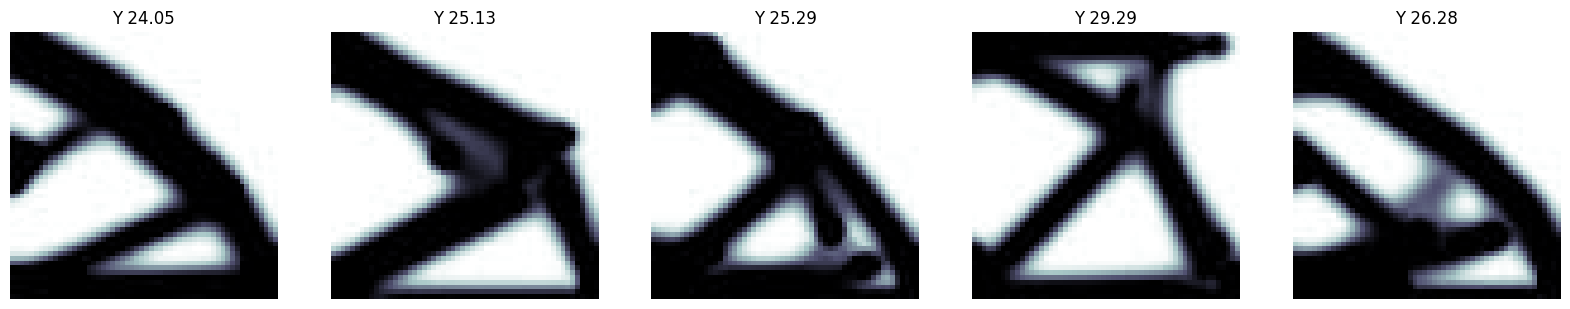

In [ ]:
# display images
fig = plt.figure(figsize=(20,10))
nplot = 5

for i in range(1,nplot+1):
    ax = fig.add_subplot(1,nplot,i)
    ax.imshow(X[i, :, :],cmap = plt.cm.bone)
    ax.set_title(f"Y {Y[i]:.2f}")
    ax.axis('off')
plt.show()

## 5. Define dataloader

In [ ]:
# split the data into 80% training set and 20% test set (test set can be considered as validation)
train_images, test_images, train_labels, test_labels = train_test_split(X,Y, test_size=0.2, random_state=1,shuffle=True)

# print the shapes and types of the training and test datasets
print(np.shape(train_images), np.shape(test_images))
print(type(train_images), type(test_images))

print(np.shape(train_labels),np.shape(test_labels))
print(type(train_labels), type(test_labels))

# reshape the (image,image) images into (image*image,) size vectors
train_images = train_images.reshape((len(train_images), np.prod(train_images.shape[1:]))).astype('float32')
test_images = test_images.reshape((len(test_images), np.prod(test_images.shape[1:]))).astype('float32')

print("Datasets_train_shape:{}  Datasets_test_shape:{}".format(np.shape(train_images),np.shape(test_images)))

# convert data to PyTorch tensors
train_images = torch.tensor(train_images, dtype=torch.float32).to(device)
train_labels = torch.tensor(train_labels, dtype=torch.float32) # don't need to use labels
test_images = torch.tensor(test_images, dtype=torch.float32).to(device)
test_labels = torch.tensor(test_labels, dtype=torch.float32)   # don't need to use labels

(1600, 56, 56) (400, 56, 56)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(1600,) (400,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
Datasets_train_shape:(1600, 3136)  Datasets_test_shape:(400, 3136)


## 6. Set to model architecture

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(image_size, mid_dim),
            nn.ReLU(),
            nn.Linear(mid_dim, h_dim),
            nn.ReLU())

        self.decoder = nn. Sequential(
            nn.Linear(h_dim, mid_dim),
            nn.ReLU(),
            nn.Linear(mid_dim, image_size),
            nn.ReLU())

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)

        return decoded

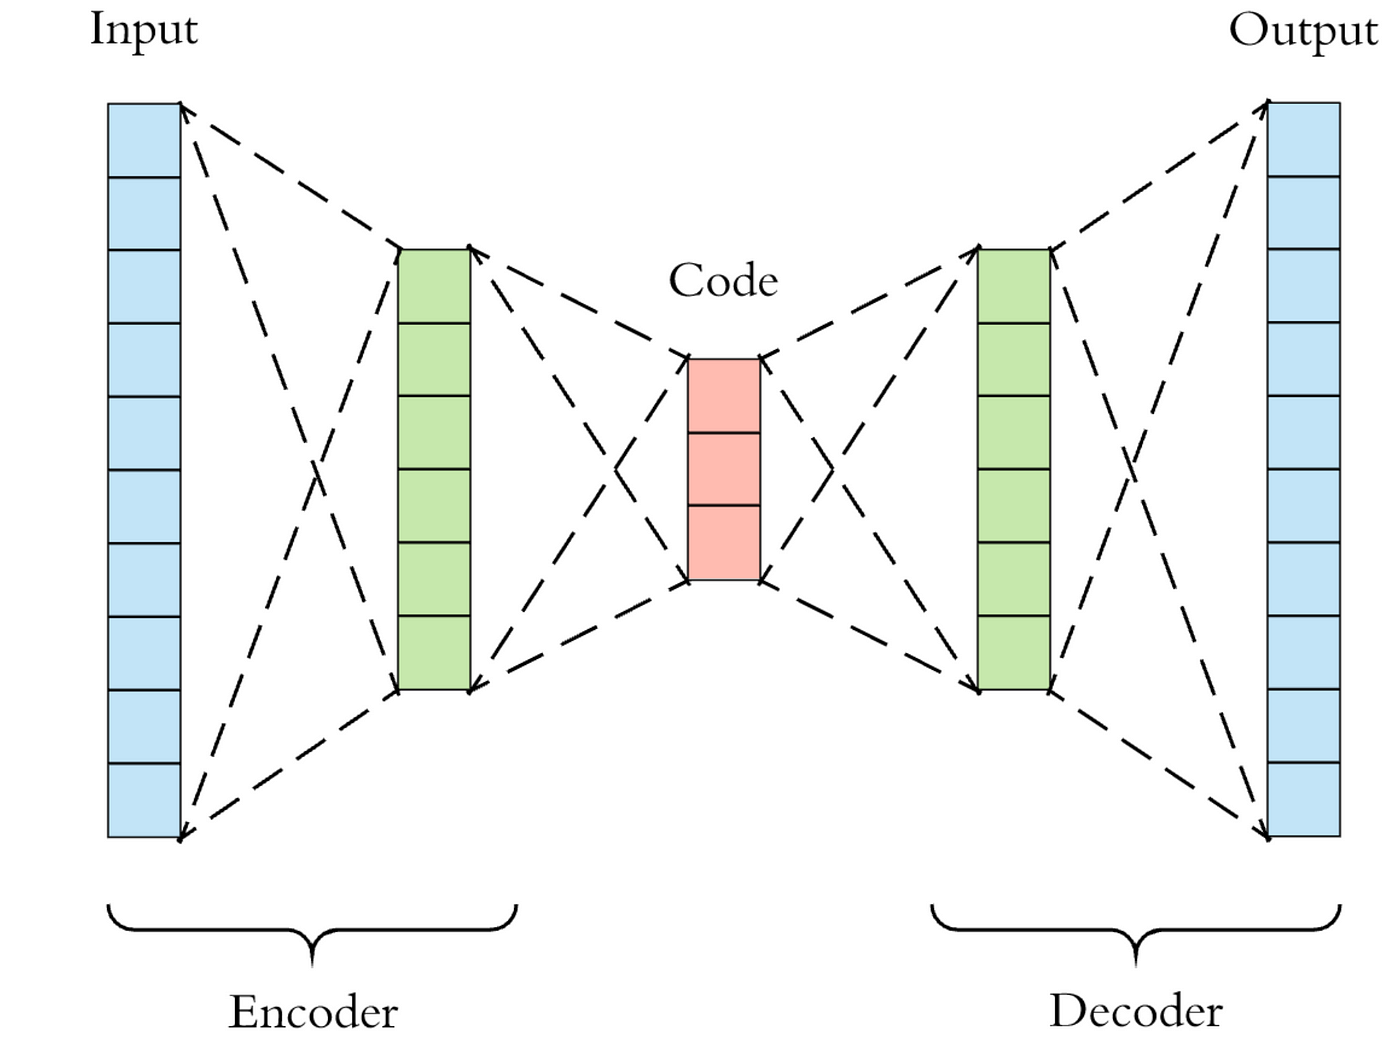

## 7. Set model hyperparameters

In [ ]:
# model architecture parameters
image_size = np.shape(train_images[0])[0]  # (fixed) input size
mid_dim = 512  # hidden layer(middle) dimension
h_dim = 20  # hidden layer(latent) dimension

# training parameters
num_epochs = 200
batch_size = 20
learning_rate = 1e-3

In [ ]:
autoencoder = Autoencoder().to(device)

# print the model's summary
summary(autoencoder, (image_size,))  # input shape: (channels, height, width)

autoencoder

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]       1,606,144
              ReLU-2                  [-1, 512]               0
            Linear-3                   [-1, 20]          10,260
              ReLU-4                   [-1, 20]               0
            Linear-5                  [-1, 512]          10,752
              ReLU-6                  [-1, 512]               0
            Linear-7                 [-1, 3136]       1,608,768
              ReLU-8                 [-1, 3136]               0
Total params: 3,235,924
Trainable params: 3,235,924
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.06
Params size (MB): 12.34
Estimated Total Size (MB): 12.42
----------------------------------------------------------------


Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=3136, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=20, bias=True)
    (3): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=20, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=3136, bias=True)
    (3): ReLU()
  )
)

## 8. Train model

In [ ]:
# create DataLoader for training and validation data
train_dataset = TensorDataset(train_images, train_images)  # labels are not needed in autoencoder
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# set to loss function & optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=learning_rate)

# train the model
for epoch in range(num_epochs):
    autoencoder.train()
    total_loss = 0.0

    for x, _ in train_loader:
        optimizer.zero_grad()
        output = autoencoder(x)
        loss = criterion(output, x)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    average_loss_train = total_loss / len(train_loader)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train_loss: {average_loss_train}")

# Save the model
torch.save(autoencoder.state_dict(), 'AE_model.pth')

Epoch [1/200], Train_loss: 0.1520272299647331
Epoch [2/200], Train_loss: 0.07755443514324725
Epoch [3/200], Train_loss: 0.06116704531013965
Epoch [4/200], Train_loss: 0.05501796789467335
Epoch [5/200], Train_loss: 0.05141936088912189
Epoch [6/200], Train_loss: 0.048014480248093606
Epoch [7/200], Train_loss: 0.046034509083256125
Epoch [8/200], Train_loss: 0.04328663474880159
Epoch [9/200], Train_loss: 0.04116610987111926
Epoch [10/200], Train_loss: 0.0400692718103528
Epoch [11/200], Train_loss: 0.03935415060259402
Epoch [12/200], Train_loss: 0.03826702176593244
Epoch [13/200], Train_loss: 0.036430669599212706
Epoch [14/200], Train_loss: 0.035349227767437694
Epoch [15/200], Train_loss: 0.03463720579165965
Epoch [16/200], Train_loss: 0.033521141251549126
Epoch [17/200], Train_loss: 0.032802519481629135
Epoch [18/200], Train_loss: 0.032268641889095305
Epoch [19/200], Train_loss: 0.031875604088418184
Epoch [20/200], Train_loss: 0.031306721223518255
Epoch [21/200], Train_loss: 0.030647445772

## 9. Load & Evaluate model

- Compare the orginial image and the reconstructed image

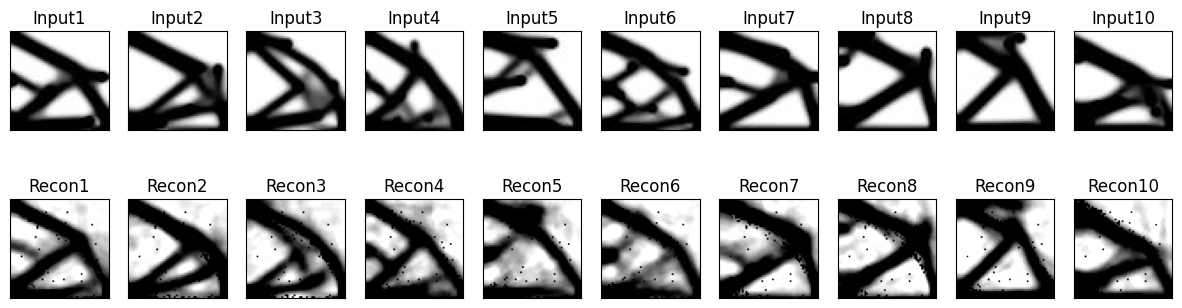

In [ ]:
autoencoder.eval().to(device)

# proceed reconstruction of the bracket images through the trained autoencoder model
recon_x_test = autoencoder(test_images)

n = 10  # how many images to display

plt.figure(figsize=(15, 4)) # figure size

for i in range(n):

    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(test_images.cpu()[i].reshape(56,56), vmin=0, vmax=1, cmap="gray")  # reshape the images to show
    plt.title("Input"+str(i+1))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(recon_x_test.detach().cpu()[i].reshape(56, 56),vmin=0, vmax=1, cmap="gray")  # reshape the images to show
    plt.title("Recon"+str(i+1))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()